<a href="https://colab.research.google.com/github/Reemaalt/Detection-of-Hallucination-in-Arabic/blob/main/XOR_ThresholdExp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import json

def count_non_hallucinated_questions(input_file):
    # Load the data
    with open(input_file, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # Count non-hallucinated questions
    non_hallucinated_questions = {key: data[key] for key in data if data[key].get("question_label") != "Hallucinated"}
    count = len(non_hallucinated_questions)

    print(f"Number of non-hallucinated questions: {count}")
    print("Non-hallucinated questions:", json.dumps(non_hallucinated_questions, ensure_ascii=False, indent=4))

    return count


input_file = "/content/human_sample_xor_tydiqa.json"

# Count non-hallucinated questions
count_non_hallucinated_questions(input_file)



Number of non-hallucinated questions: 19
Non-hallucinated questions: {
    "3594222040211173813": {
        "question": "من هم القوط؟",
        "original_answer": "قبائل جرمانية شرقية",
        "clusters": [
            {
                "cluster_number": 0,
                "answers": [
                    [
                        "قبل أن ينت",
                        90.80878448486328,
                        "Hallucinated"
                    ]
                ],
                "total_neg_log_likelihoods_for_cluster": 90.80878448486328
            },
            {
                "cluster_number": 1,
                "answers": [
                    [
                        "القوط هم شعباً جرمانياً عاشوا في أوروبا الغربية في العصور الوسطى، كانوا يعتبرون من القبائل الجرمانية التي هاجرت إلى أوروبا الغربية",
                        77.43145751953125,
                        "Non-Hallucinated"
                    ]
                ],
                "total_neg_log_likelihoods_for_clust

19

In [4]:
import json
import numpy as np

# Load JSON file
with open("/content/human_sample_xor_tydiqa.json", "r", encoding="utf-8") as file:
    data = json.load(file)

# Dictionary to store confidence scores for each cluster number (1 to 10)
confidence_scores = {i: [] for i in range(1, 11)}

for question_id, question_data in data.items():
    # Filter only questions labeled as "Non-Hallucinated"
    if question_data.get("question_label") == "Non-Hallucinated":
        clusters = question_data.get("clusters", [])  # List of clusters
        num_clusters = len(clusters)  # Count of clusters

        # Compute confidence score (number of non-hallucinated answers out of 10)
        non_hallucinated_count = sum(
            1 for cluster in clusters for ans_list in cluster.get("answers", []) for ans in ans_list if ans == "Non-Hallucinated"
        )
        confidence_score = non_hallucinated_count / 10.0

        if 1 <= num_clusters <= 10:
            confidence_scores[num_clusters].append(confidence_score)

# Compute the average confidence score for each cluster count
average_confidence_scores = {
    clusters: np.mean(scores) if scores else 0 for clusters, scores in confidence_scores.items()
}

# Print confidence scores dictionary
print("Confidence scores by cluster count:", confidence_scores)

# Find the optimal threshold (highest average confidence score)
optimal_threshold = max(average_confidence_scores, key=average_confidence_scores.get)
print("Optimal cluster threshold:", optimal_threshold)


Confidence scores by cluster count: {1: [], 2: [0.9], 3: [0.9], 4: [0.7, 0.9, 0.8], 5: [0.7, 0.7, 0.8], 6: [0.9, 0.9, 0.6], 7: [0.6, 0.6, 0.8, 0.8], 8: [0.7, 0.6, 0.8], 9: [], 10: [0.6]}
Optimal cluster threshold: 2


In [5]:

# Create a new labeled dataset of sample using the optimal threshold
new_data = {}
for question_id, question_data in data.items():
    num_clusters = len(question_data.get("clusters", []))
    threshold_label = "Hallucinated" if num_clusters > optimal_threshold else "Non-Hallucinated"
    new_data[question_id] = {**question_data, "threshold_label": threshold_label}

# Save the new JSON file with the updated threshold label
new_file_name = "labeled_sample_XOR_dataThreshold.json"
with open(new_file_name, "w", encoding="utf-8") as f:
    json.dump(new_data, f, ensure_ascii=False, indent=4)

print(f"threshold labeled file saved as '{new_file_name}'.")


threshold labeled file saved as 'labeled_sample_XOR_dataThreshold.json'.


Unique true labels and their counts: {0: 19, 1: 81}
AUROC Score: 0.7833
AUROC Score: 0.7833


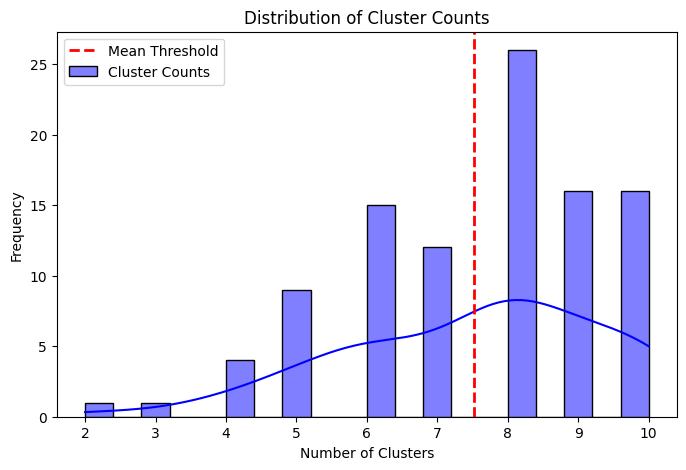

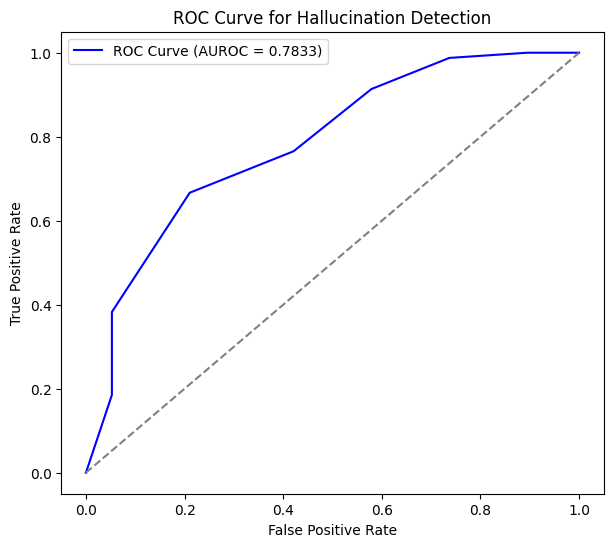

In [6]:
#evaluation on sample
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve

# Load the dataset with the new threshold-based labels
with open("labeled_sample_XOR_dataThreshold.json", "r", encoding="utf-8") as file:
    data = json.load(file)

# Extract ground truth labels and predicted labels
true_labels = []
pred_scores = []  # This will store the number of clusters (used as a score)
predicted_labels = []  # This will store the predicted labels based on the threshold

for question_id, question_data in data.items():
    # Convert string labels to numerical (1 = hallucinated, 0 = non-hallucinated)
    true_label = 1 if question_data.get("question_label") == "Hallucinated" else 0
    predicted_label = 1 if question_data.get("threshold_label") == "Hallucinated" else 0

    # Store ground truth and predicted scores
    true_labels.append(true_label)
    pred_scores.append(len(question_data.get("clusters", [])))  # Use cluster count as a prediction score
    predicted_labels.append(predicted_label)
# Debug: Print unique values in true_labels
print("Unique true labels and their counts:", {label: true_labels.count(label) for label in set(true_labels)})

# Ensure there are both classes (0 and 1) before computing AUROC
if len(set(true_labels)) < 2:
    print("Error: Only one class is present in true_labels. AUROC cannot be computed.")
else:
    auroc = roc_auc_score(true_labels, pred_scores)
    print(f"AUROC Score: {auroc:.4f}")
# Compute AUROC score
auroc = roc_auc_score(true_labels, pred_scores)
print(f"AUROC Score: {auroc:.4f}")

# Plot Histogram of Cluster Counts
plt.figure(figsize=(8, 5))
sns.histplot(pred_scores, bins=20, kde=True, color='blue', label="Cluster Counts")
plt.axvline(np.mean(pred_scores), color='red', linestyle='dashed', linewidth=2, label="Mean Threshold")
plt.xlabel("Number of Clusters")
plt.ylabel("Frequency")
plt.title("Distribution of Cluster Counts")
plt.legend()
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(true_labels, pred_scores)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUROC = {auroc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Hallucination Detection")
plt.legend()
plt.show()


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Compute classification metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.8200
Precision: 0.8182
Recall: 1.0000
F1 Score: 0.9000


In [8]:
import json
# Load the dataset XOR full answers generated and evaluate method after doing rouge l labeling
# Load JSON file
with open("/content/labeled_data_XORfull_rougel_isri.json", "r", encoding="utf-8") as file:
    data = json.load(file)

# Create a new labeled dataset of sample using the optimal threshold
new_data = {}
for question_id, question_data in data.items():
    num_clusters = len(question_data.get("clusters", []))
    threshold_label = "Hallucinated" if num_clusters > optimal_threshold else "Non-Hallucinated"
    new_data[question_id] = {**question_data, "threshold_label": threshold_label}

# Save the new JSON file with the updated threshold label
new_file_name = "labeled_fullXOR_dataThreshold.json"
with open(new_file_name, "w", encoding="utf-8") as f:
    json.dump(new_data, f, ensure_ascii=False, indent=4)

print(f"threshold labeled file saved as '{new_file_name}'.")



threshold labeled file saved as 'labeled_fullXOR_dataThreshold.json'.


Unique true labels and their counts: {0: 31, 1: 677}
AUROC Score: 0.8202
AUROC Score: 0.8202


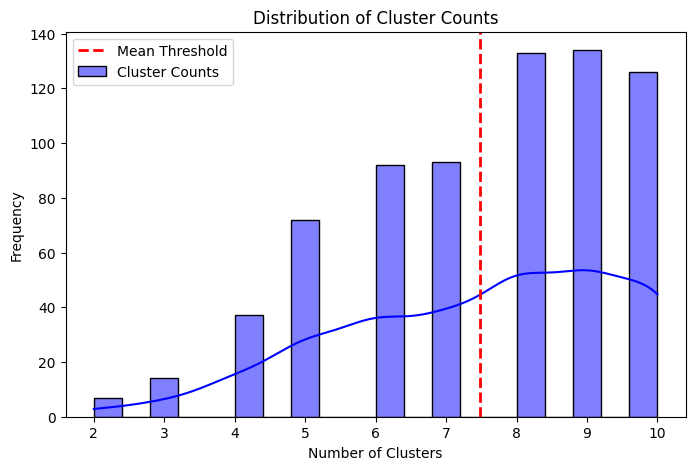

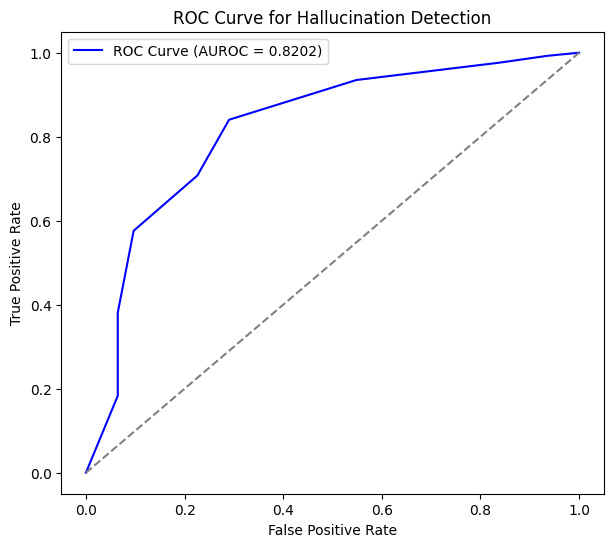


Final Statistics:
Computed Labels - Hallucinated: 677, Non-Hallucinated: 31
Threshold Labels - Hallucinated: 701, Non-Hallucinated: 7


In [12]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve

# Load the dataset with the new threshold-based labels
with open("/content/labeled_fullXOR_dataThreshold.json", "r", encoding="utf-8") as file:
    data = json.load(file)

# Extract ground truth labels and predicted labels
true_labels = []
pred_scores = []  # This will store the number of clusters (used as a score)
predicted_labels = []  # This will store the predicted labels based on the threshold

# Counters for computed and threshold labels
computed_hallucinated = 0
computed_non_hallucinated = 0
threshold_hallucinated = 0
threshold_non_hallucinated = 0

for question_id, question_data in data.items():
    # Convert string labels to numerical (1 = hallucinated, 0 = non-hallucinated)
    computed_label = question_data.get("computed_question_label")
    threshold_label = question_data.get("threshold_label")

    true_label = 1 if computed_label == "Hallucinated" else 0
    predicted_label = 1 if threshold_label == "Hallucinated" else 0

    # Store ground truth and predicted scores
    true_labels.append(true_label)
    pred_scores.append(len(question_data.get("clusters", [])))  # Use cluster count as a prediction score
    predicted_labels.append(predicted_label)

    # Count computed labels
    if computed_label == "Hallucinated":
        computed_hallucinated += 1
    else:
        computed_non_hallucinated += 1

    # Count threshold labels
    if threshold_label == "Hallucinated":
        threshold_hallucinated += 1
    else:
        threshold_non_hallucinated += 1

# Debug: Print unique values in true_labels
print("Unique true labels and their counts:", {label: true_labels.count(label) for label in set(true_labels)})

# Ensure there are both classes (0 and 1) before computing AUROC
if len(set(true_labels)) < 2:
    print("Error: Only one class is present in true_labels. AUROC cannot be computed.")
else:
    auroc = roc_auc_score(true_labels, pred_scores)
    print(f"AUROC Score: {auroc:.4f}")

# Compute AUROC score
auroc = roc_auc_score(true_labels, pred_scores)
print(f"AUROC Score: {auroc:.4f}")

# Plot Histogram of Cluster Counts
plt.figure(figsize=(8, 5))
sns.histplot(pred_scores, bins=20, kde=True, color='blue', label="Cluster Counts")
plt.axvline(np.mean(pred_scores), color='red', linestyle='dashed', linewidth=2, label="Mean Threshold")
plt.xlabel("Number of Clusters")
plt.ylabel("Frequency")
plt.title("Distribution of Cluster Counts")
plt.legend()
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(true_labels, pred_scores)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUROC = {auroc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Hallucination Detection")
plt.legend()
plt.show()

# Print final statistics
print("\nFinal Statistics:")
print(f"Computed Labels - Hallucinated: {computed_hallucinated}, Non-Hallucinated: {computed_non_hallucinated}")
print(f"Threshold Labels - Hallucinated: {threshold_hallucinated}, Non-Hallucinated: {threshold_non_hallucinated}")


In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Compute classification metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9520
Precision: 0.9586
Recall: 0.9926
F1 Score: 0.9753
